<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Preparing" data-toc-modified-id="Data-Preparing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Preparing</a></span></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Modeling</a></span></li><li><span><a href="#Inference" data-toc-modified-id="Inference-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Inference</a></span><ul class="toc-item"><li><span><a href="#Principal-Component-Analysis" data-toc-modified-id="Principal-Component-Analysis-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Principal Component Analysis</a></span></li></ul></li></ul></div>

In [23]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Layer, Dense, Flatten, Dropout, Concatenate, Add, Dot, Multiply, Reshape, Activation, BatchNormalization, LayerNormalization, SimpleRNNCell, RNN, SimpleRNN, LSTM, Embedding, Bidirectional, TimeDistributed, Conv1D, Conv1DTranspose
, Conv2D, Conv2DTranspose
, MaxPool1D, MaxPool2D, GlobalMaxPool1D, GlobalMaxPool2D, AveragePooling1D, AveragePooling2D, GlobalAveragePooling1D, GlobalAveragePooling2D, ZeroPadding2D, RepeatVector
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adagrad, Adam
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
# MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError, BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy, CosineSimilarity
from tensorflow.keras import losses
# MeanSquaredError, RootMeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError, BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy, CosineSimilarity
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.activations import linear, sigmoid, relu
from tensorflow.keras.initializers import RandomNormal, glorot_uniform, he_uniform, Constant

plt.style.use("dark_background")

In [5]:
results_path = Path("autoencoder")
if not results_path.exists():
    results_path.mkdir()

experiment = 0

log_dir = results_path / f"experiment_{experiment:02}"
if not log_dir.exists():
    log_dir.mkdir(parents=True)

hdf_store = results_path / "AutoEncoder.h5"

In [6]:
hdf_store

WindowsPath('autoencoder/AutoEncoder.h5')

# Data Preparing

In [34]:
try:
    data = pd.read_hdf(hdf_store, "data/real")
except:
    tickers = ["BA", "CAT","DIS", "GE", "IBM", "KO", "AAPL", "FB", "TSLA"] # 주식 목록. => 특징 분석을 수행할 주식의 목록
    # HDF => .h5을 읽는 코드. quandl => 주식에 대한 다양한 시계열을 제공
    # quandl 데이터에서 주가 정보를 가져오겠다.
    data = pd.read_hdf("/assets.h5", "quandl/wiki/prices")
    data = data["adj_close"]
    data = data.unstack("ticker")
    data = data.loc["2000":, tickers]
    data = data.dropna()
    data.to_hdf(hdf_store, "data/real")

In [20]:
data.head()

ticker,BA,CAT,DIS,GE,IBM,KO,AAPL,FB,TSLA
date,,,,,,,,,
2012-05-18,60.032758,74.702335,40.675603,15.791293,167.027133,31.304654,68.161222,38.2318,27.56
2012-05-21,62.316000,77.482192,41.214107,15.932957,168.630211,31.499119,72.132303,34.0300,28.77
2012-05-22,62.055554,77.069425,41.214107,15.982955,167.828672,31.363839,71.578408,31.0000,30.79
2012-05-23,62.133687,77.894959,41.046985,15.982955,167.231781,31.516029,73.324912,32.0000,31.02
2012-05-24,61.977420,77.010459,41.260530,16.041287,167.206200,31.943007,72.651499,33.0300,30.32


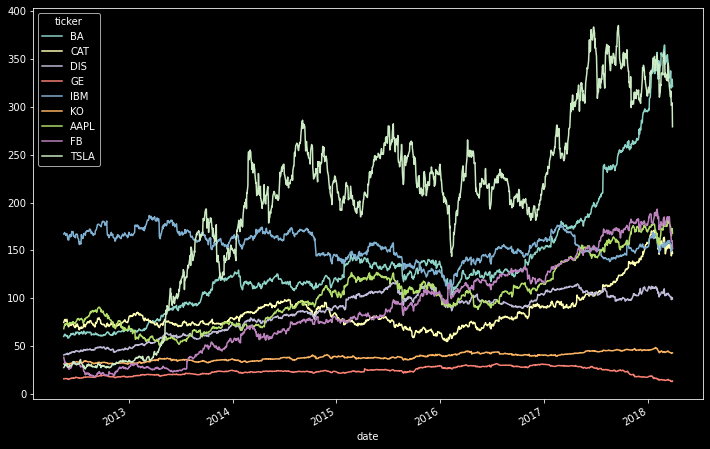

In [29]:
data.plot.line(figsize=(12, 8));

In [10]:
df_values = data.values # 주가 데이터의 값만 추출

In [11]:
df_values

array([[ 60.03275797,  74.70233523,  40.6756033 , ...,  68.16122225,
         38.2318    ,  27.56      ],
       [ 62.31599952,  77.48219209,  41.21410707, ...,  72.13230292,
         34.03      ,  28.77      ],
       [ 62.05555371,  77.06942546,  41.21410707, ...,  71.57840785,
         31.        ,  30.79      ],
       ...,
       [321.        , 144.29      ,  98.54      , ..., 164.94      ,
        159.39      , 301.54      ],
       [328.97      , 149.19      , 100.65      , ..., 172.77      ,
        160.06      , 304.18      ],
       [321.12      , 146.99      ,  99.36      , ..., 168.34      ,
        152.19      , 279.18      ]])

In [13]:
x_train = df_values.transpose()

In [14]:
x_train

array([[ 60.03275797,  62.31599952,  62.05555371, ..., 321.        ,
        328.97      , 321.12      ],
       [ 74.70233523,  77.48219209,  77.06942546, ..., 144.29      ,
        149.19      , 146.99      ],
       [ 40.6756033 ,  41.21410707,  41.21410707, ...,  98.54      ,
        100.65      ,  99.36      ],
       ...,
       [ 68.16122225,  72.13230292,  71.57840785, ..., 164.94      ,
        172.77      , 168.34      ],
       [ 38.2318    ,  34.03      ,  31.        , ..., 159.39      ,
        160.06      , 152.19      ],
       [ 27.56      ,  28.77      ,  30.79      , ..., 301.54      ,
        304.18      , 279.18      ]])

In [15]:
# 평균과 편차를 활용해서 정규화 => 수익률 = (수익률 - 평균수익률) / (수익률의 표준편차)
normalized_x = []
means = []
stds = []
for x in x_train:
    x_mean = np.mean(x)
    x_std = np.std(x)
    means.append(x_mean)
    stds.append(stds)
    normalized_x.append((x - x_mean) / x_std)

In [16]:
normalized_x = np.array(normalized_x)

In [17]:
normalized_x

array([[-1.20895665, -1.17291493, -1.17702615, ...,  2.9104973 ,
         3.03630637,  2.91239154],
       [-0.52262305, -0.39835935, -0.41681063, ...,  2.58804815,
         2.80708537,  2.70874213],
       [-2.03458249, -2.01004147, -2.01004147, ...,  0.60244891,
         0.69860711,  0.63981845],
       ...,
       [-1.06371652, -0.94324542, -0.96004899, ...,  1.8722716 ,
         2.10981115,  1.97541777],
       [-1.05580316, -1.14245756, -1.20494574, ...,  1.44286193,
         1.45667945,  1.29437517],
       [-1.84520436, -1.8323474 , -1.81088371, ...,  1.06599393,
         1.09404548,  0.82840581]])

In [18]:
# 주식의 숫자, 날짜의 갯수 => 몇일치 데이터가 있는지 => 주식의 숫자, 날짜의 갯수, 데이터의 갯수
normalized_x.shape

(9, 1471)

In [19]:
# 주식의 숫자, 날짜의 갯수 => 몇일치 데이터가 있는지 => 주식의 숫자, 날짜의 갯수, 데이터의 갯수
# reshape => 데이터의 형태를 바꾸는 함수.
# normalized_x = normalized_x.reshape(6, 4586, 1) # 6개 주식을 썼던 코드
# normalized_x = normalized_x.reshape(9, 1471, 1) # 9개 주식을 썼던 코드
# 주식의 갯수,         날짜의 갯수
normalized_x = normalized_x.reshape(normalized_x.shape[0], normalized_x.shape[1], 1) # 주식의 숫자, 날짜의 갯수 => 몇일치 데이터가 있는지 => 주식의 숫자, 날짜의 갯수, 데이터의 갯수

In [20]:
normalized_x.shape

(9, 1471, 1)

In [ ]:
normalized_x

array([[[-1.20895665],
        [-1.17291493],
        [-1.17702615],
        ...,
        [ 2.9104973 ],
        [ 3.03630637],
        [ 2.91239154]],

       [[-0.52262305],
        [-0.39835935],
        [-0.41681063],
        ...,
        [ 2.58804815],
        [ 2.80708537],
        [ 2.70874213]],

       [[-2.03458249],
        [-2.01004147],
        [-2.01004147],
        ...,
        [ 0.60244891],
        [ 0.69860711],
        [ 0.63981845]],

       ...,

       [[-1.06371652],
        [-0.94324542],
        [-0.96004899],
        ...,
        [ 1.8722716 ],
        [ 2.10981115],
        [ 1.97541777]],

       [[-1.05580316],
        [-1.14245756],
        [-1.20494574],
        ...,
        [ 1.44286193],
        [ 1.45667945],
        [ 1.29437517]],

       [[-1.84520436],
        [-1.8323474 ],
        [-1.81088371],
        ...,
        [ 1.06599393],
        [ 1.09404548],
        [ 0.82840581]]])

# Modeling

In [22]:
timesteps = normalized_x.shape[1]  # Length of your sequences
input_dim = 1
latent_dim = 500
# 모델의 복잡도 => 모델링 할 주식 특성 갯수. => 많으면 좋으냐? => 정답은 아니고, 우리가 세운 가설이 몇개냐?

inputs = Input(shape=(timesteps, input_dim))

# ENCODER
encoded = LSTM(latent_dim, return_sequences=False)(inputs) 
encoded = Dense(units=100)(encoded) # 모델링할 팩터의 개수 지정. => z_vec

# DECODER
decoded = RepeatVector(timesteps)(encoded) # decoder
decoded = LSTM(input_dim, return_sequences=True)(decoded)

sequence_autoencoder = Model(inputs, decoded) # 모델의 시작: 입력, 모델의 끝: 디코더의 출력.
encoder = Model(inputs, encoded) # 모델의 시작: 입력, 모델의 끝: 인코더의 출력

In [23]:
sequence_autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1471, 1)]         0         
                                                                 
 lstm_2 (LSTM)               (None, 500)               1004000   
                                                                 
 dense_1 (Dense)             (None, 100)               50100     
                                                                 
 repeat_vector_1 (RepeatVect  (None, 1471, 100)        0         
 or)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 1471, 1)           408       
                                                                 
Total params: 1,054,508
Trainable params: 1,054,508
Non-trainable params: 0
_________________________________________________

In [24]:
encoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1471, 1)]         0         
                                                                 
 lstm_2 (LSTM)               (None, 500)               1004000   
                                                                 
 dense_1 (Dense)             (None, 100)               50100     
                                                                 
Total params: 1,054,100
Trainable params: 1,054,100
Non-trainable params: 0
_________________________________________________________________


In [25]:
sequence_autoencoder.compile(optimizer="adam", loss="mae")

In [ ]:
sequence_autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4586, 1)]         0         
                                                                 
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 repeat_vector (RepeatVector  (None, 4586, 128)        0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 4586, 1)           520       
                                                                 
Total params: 67,080
Trainable params: 67,080
Non-trainable params: 0
_________________________________________________________________


In [26]:
sequence_autoencoder.fit(normalized_x, normalized_x, epochs=100)

Epoch 1/100
1/1 [==============================] - 7s 7s/step - loss: 0.7950
Epoch 2/100
1/1 [==============================] - 1s 593ms/step - loss: 0.8319
Epoch 3/100
1/1 [==============================] - 1s 555ms/step - loss: 0.8265
Epoch 4/100
1/1 [==============================] - 1s 556ms/step - loss: 0.8226
Epoch 5/100
1/1 [==============================] - 1s 553ms/step - loss: 0.8099
Epoch 6/100
1/1 [==============================] - 1s 558ms/step - loss: 0.7941
Epoch 7/100
1/1 [==============================] - 1s 553ms/step - loss: 0.7931
Epoch 8/100
1/1 [==============================] - 1s 558ms/step - loss: 0.7933
Epoch 9/100
1/1 [==============================] - 1s 564ms/step - loss: 0.7858
Epoch 10/100
1/1 [==============================] - 1s 565ms/step - loss: 0.7872
Epoch 11/100
1/1 [==============================] - 1s 569ms/step - loss: 0.7894
Epoch 12/100
1/1 [==============================] - 1s 567ms/step - loss: 0.7881
Epoch 13/100
1/1 [======================

# Inference

In [27]:
# encoder에 입력을 넣음.
x_test_encoded = encoder.predict(normalized_x)

In [28]:
x_test_encoded

array([[ 9.18509886e-02,  2.78938949e-01,  3.22840244e-01,
         3.74431014e-02,  2.18767777e-01,  1.05942674e-01,
        -1.40180081e-01, -1.37707703e-02, -2.03555509e-01,
         6.30726740e-02,  6.93483949e-02, -1.21977441e-01,
         1.00251986e-02, -1.19057354e-02,  1.75799578e-02,
        -1.05351694e-01, -2.02406362e-01, -9.72171351e-02,
        -1.76760837e-01, -8.73375125e-03,  2.63729215e-01,
         6.58121705e-02, -9.55948010e-02, -3.14719319e-01,
         6.06788322e-02,  8.13226625e-02,  1.10467702e-01,
         1.34640753e-01,  2.34001964e-01,  2.57571042e-01,
         3.58064808e-02,  2.39250213e-01,  9.02004354e-03,
        -2.00562757e-02, -1.21851109e-01,  2.02363096e-02,
         3.16216707e-01,  2.46698689e-03,  2.11975664e-01,
         5.67826889e-02,  1.06737599e-01,  3.37618262e-01,
         3.12197506e-01,  2.80258089e-01, -1.64613519e-02,
         1.72843233e-01, -3.74342561e-01,  1.25705972e-01,
        -4.20282871e-01,  1.34723395e-01, -2.51112193e-0

In [29]:
x_test_encoded.shape

(9, 100)

## Principal Component Analysis

In [30]:
# PCA => 주성분 분석 => 주성분을 가지고 클러스터링. => 500차원 벡터 => 2차원 => 시각화.

            # 축소 시킬 차원의 갯수.
tsne = TSNE(n_components=2, verbose=1, n_iter=300, perplexity=5)
                            # z-vector를 TSNE에 넣어서 2차원 값으로 축소.
tsne_v = tsne.fit_transform(x_test_encoded)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 8 nearest neighbors...
[t-SNE] Indexed 9 samples in 0.000s...
[t-SNE] Computed neighbors for 9 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 9 / 9
[t-SNE] Mean sigma: 0.889745
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.542587
[t-SNE] KL divergence after 300 iterations: 0.503885


In [31]:
tsne_v

array([[ 170.7188   ,   -7.6343956],
       [  -4.5393853,  199.80008  ],
       [-109.76383  ,   -3.2694597],
       [-194.7065   ,  149.52773  ],
       [ 129.20985  ,  140.54575  ],
       [  -1.0178468,  -18.90888  ],
       [  -1.0688896,  303.4988   ],
       [   9.13349  ,   79.16946  ],
       [ -35.569244 , -112.85007  ]], dtype=float32)

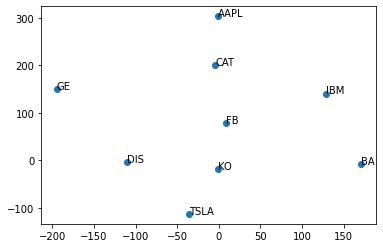

In [32]:
plt.scatter(tsne_v[:, 0], tsne_v[:, 1])
# ax.scatter(tsne_v[:, 0], tsne_v[:, 1])
for i, txt in enumerate(tickers):
    plt.annotate(txt, (tsne_v[:, 0][i], tsne_v[:, 1][i]))
# plt.colorbar()
plt.show()

In [ ]:
df

ticker,BA,CAT,DIS,GE,IBM,KO
date,,,,,,
2000-01-03,27.180308,14.984244,23.839401,29.005613,85.155442,17.779754
2000-01-04,27.139731,14.790123,25.235618,27.845388,82.263093,17.839810
2000-01-05,29.040120,15.347834,26.129196,27.797045,85.155442,18.035783
2000-01-06,29.121276,15.908626,25.235618,28.168317,83.687245,18.016818
2000-01-07,29.966645,16.426281,24.836699,29.258928,83.320195,19.202135
...,...,...,...,...,...,...
2018-03-21,337.100000,155.800000,101.820000,13.880000,156.690000,43.000000
2018-03-22,319.610000,146.900000,100.600000,13.350000,152.090000,42.760000
2018-03-23,321.000000,144.290000,98.540000,13.070000,148.890000,42.330000


[t-SNE] Computing 5 nearest neighbors...
[t-SNE] Indexed 6 samples in 0.000s...
[t-SNE] Computed neighbors for 6 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 6 / 6
[t-SNE] Mean sigma: 36.950418
[t-SNE] KL divergence after 250 iterations with early exaggeration: 38.346310
[t-SNE] KL divergence after 300 iterations: 0.326128


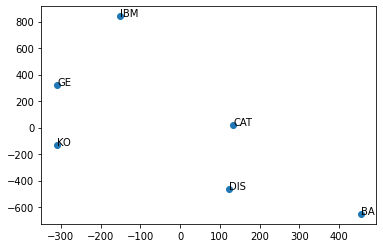

In [ ]:
x_test_encoded = encoder.predict(normalized_x)
tsne = TSNE(n_components=2, verbose=1, n_iter=300, perplexity=5)
tsne_v = tsne.fit_transform(x_test_encoded)

plt.scatter(tsne_v[:, 0], tsne_v[:, 1])
# ax.scatter(tsne_v[:, 0], tsne_v[:, 1])
for i, txt in enumerate(tickers):
    plt.annotate(txt, (tsne_v[:, 0][i], tsne_v[:, 1][i]))
# plt.colorbar()

In [ ]:
tsne = TSNE(n_components=2, verbose=1, n_iter=300, perplexity=5)

In [ ]:
tsne_v = tsne.fit_transform(x_test_encoded)

[t-SNE] Computing 5 nearest neighbors...
[t-SNE] Indexed 6 samples in 0.000s...
[t-SNE] Computed neighbors for 6 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 6 / 6
[t-SNE] Mean sigma: 47.267133
[t-SNE] KL divergence after 250 iterations with early exaggeration: 34.195358
[t-SNE] KL divergence after 300 iterations: 0.156443


In [ ]:
tsne_v

array([[-147.95686  ,   91.73948  ],
       [-117.29268  ,  -27.679321 ],
       [  64.74699  ,  195.8893   ],
       [ -99.446236 ,  216.02258  ],
       [  22.236149 ,    2.3675494],
       [ -24.006056 ,  115.34841  ]], dtype=float32)

In [ ]:
tsne_v[:, 0][i]

-38.56531